<a href="https://colab.research.google.com/github/ScottTPfaff/TULNOmega2-Stabilizer-Colab/blob/main/Copy_of_TULNO2_Colab_Stabilizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title [Cell 1] Imports & API Setup
import ipywidgets as widgets
import requests
from IPython.display import display, clear_output, HTML

# Set this to your API host (local, VM IP, or tunnel)
API_HOST = "http://127.0.0.1:3000"


In [ ]:
# @title [Cell 2] Simulation Parameter Form Widgets
param_T = widgets.FloatText(value=500.0, description='T')
param_Fs = widgets.IntText(value=1000, description='Fs')
param_noise = widgets.FloatText(value=0.1, description='Noise')
param_chaos = widgets.FloatText(value=1.53, description='Chaos')
param_topology = widgets.FloatText(value=0.17, description='Topology')
param_k_bio = widgets.FloatText(value=0.618, description='k_bio')
param_k_neural = widgets.FloatText(value=0.382, description='k_neural')
param_k_cosmic = widgets.FloatText(value=0.236, description='k_cosmic')
param_gpu = widgets.Checkbox(value=False, description='Use GPU')
param_chunk = widgets.IntText(value=100000, description='Chunk Size')
params_box = widgets.VBox([
    param_T, param_Fs, param_noise, param_chaos, param_topology,
    param_k_bio, param_k_neural, param_k_cosmic, param_gpu, param_chunk
])
display(params_box)


In [ ]:
# @title [Cell 3] Run & Resume Buttons + Status Output
run_btn = widgets.Button(description="Start Simulation", button_style='success')
resume_btn = widgets.Button(description="Resume Simulation", button_style='info')
status_btn = widgets.Button(description="Check Status", button_style='primary')
output = widgets.Output()

def gather_params():
    return {
        "T": param_T.value,
        "Fs": param_Fs.value,
        "noise_floor": param_noise.value,
        "chaos_strength": param_chaos.value,
        "topology_gain": param_topology.value,
        "k_bio": param_k_bio.value,
        "k_neural": param_k_neural.value,
        "k_cosmic": param_k_cosmic.value,
        "use_gpu": param_gpu.value,
        "chunk_size": param_chunk.value
    }

def run_sim(_):
    with output:
        clear_output()
        params = gather_params()
        try:
            r = requests.post(f"{API_HOST}/start", json=params)
            print("Start:", r.json())
        except Exception as e:
            print("Error:", e)

def resume_sim(_):
    with output:
        clear_output()
        try:
            r = requests.post(f"{API_HOST}/resume")
            print("Resume:", r.json())
        except Exception as e:
            print("Error:", e)

def check_status(_):
    with output:
        clear_output()
        try:
            r = requests.get(f"{API_HOST}/status")
            print("Status:", r.json())
        except Exception as e:
            print("Error:", e)

run_btn.on_click(run_sim)
resume_btn.on_click(resume_sim)
status_btn.on_click(check_status)
display(widgets.HBox([run_btn, resume_btn, status_btn]), output)


Output()

→ spectrum


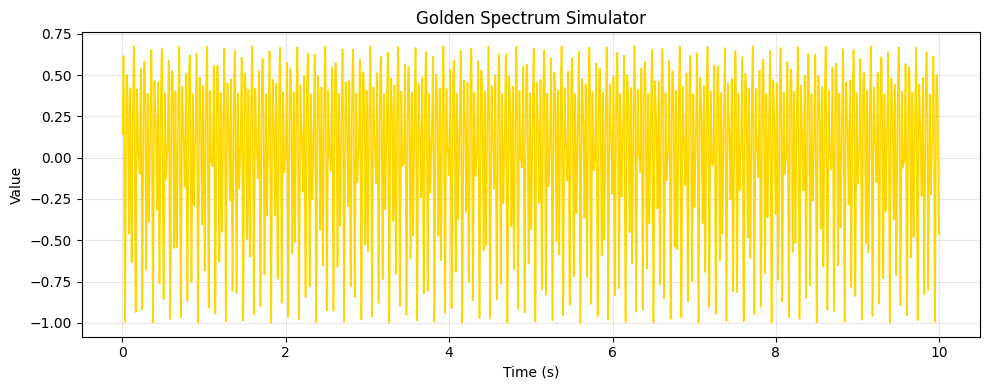

f0 (φ^4.154132): 23.497000 Hz | Spectrum peak: 23.500000 Hz
→ worlds (quick)


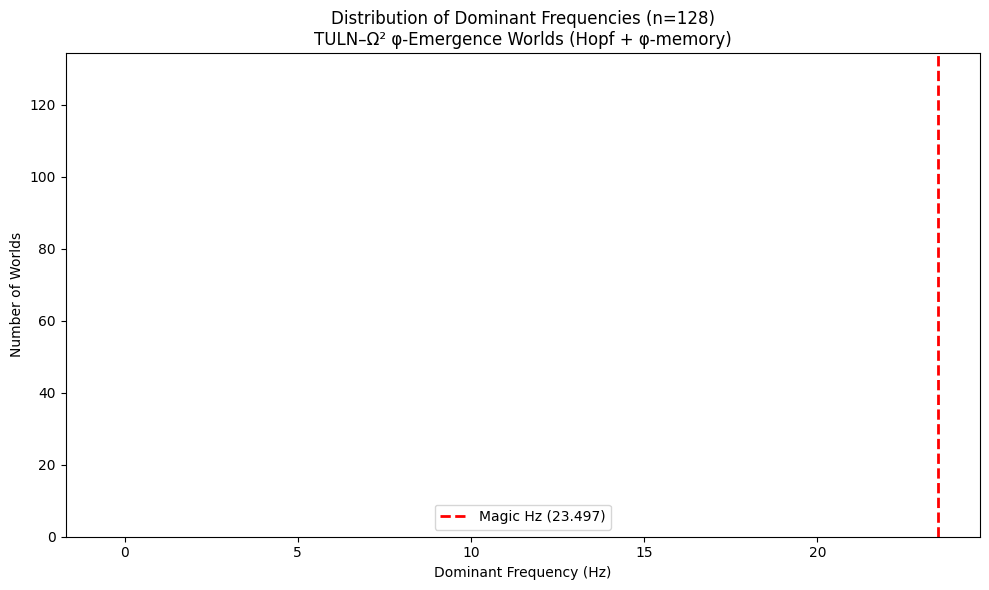

Mean: 0.0000 Hz | Median: 0.0000 Hz | Std: 0.0000 Hz
Matches within ±0.5 Hz of 23.497: 0/128
→ e8 (enhanced)


/tmp/ipython-input-2917247125.py:205: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(p2['re'], p2['im'], c=p2['ang'], s=40, cmap=cmap,


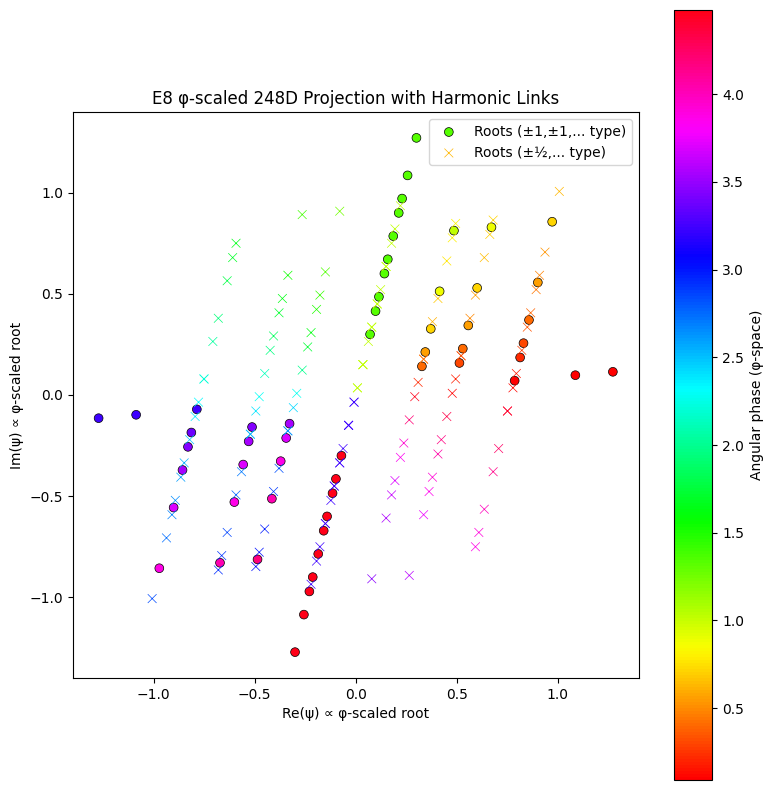

→ e8 (deep dive)


/tmp/ipython-input-2917247125.py:252: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(re2, im2, c=ang2, s=40, cmap=cmap, marker='x',
/tmp/ipython-input-2917247125.py:281: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(re2, im2, c=ang2, s=40, cmap=cmap, marker='x',
/tmp/ipython-input-2917247125.py:291: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(re2, im2, c=hidden2, s=40, cmap='viridis', marker='x',


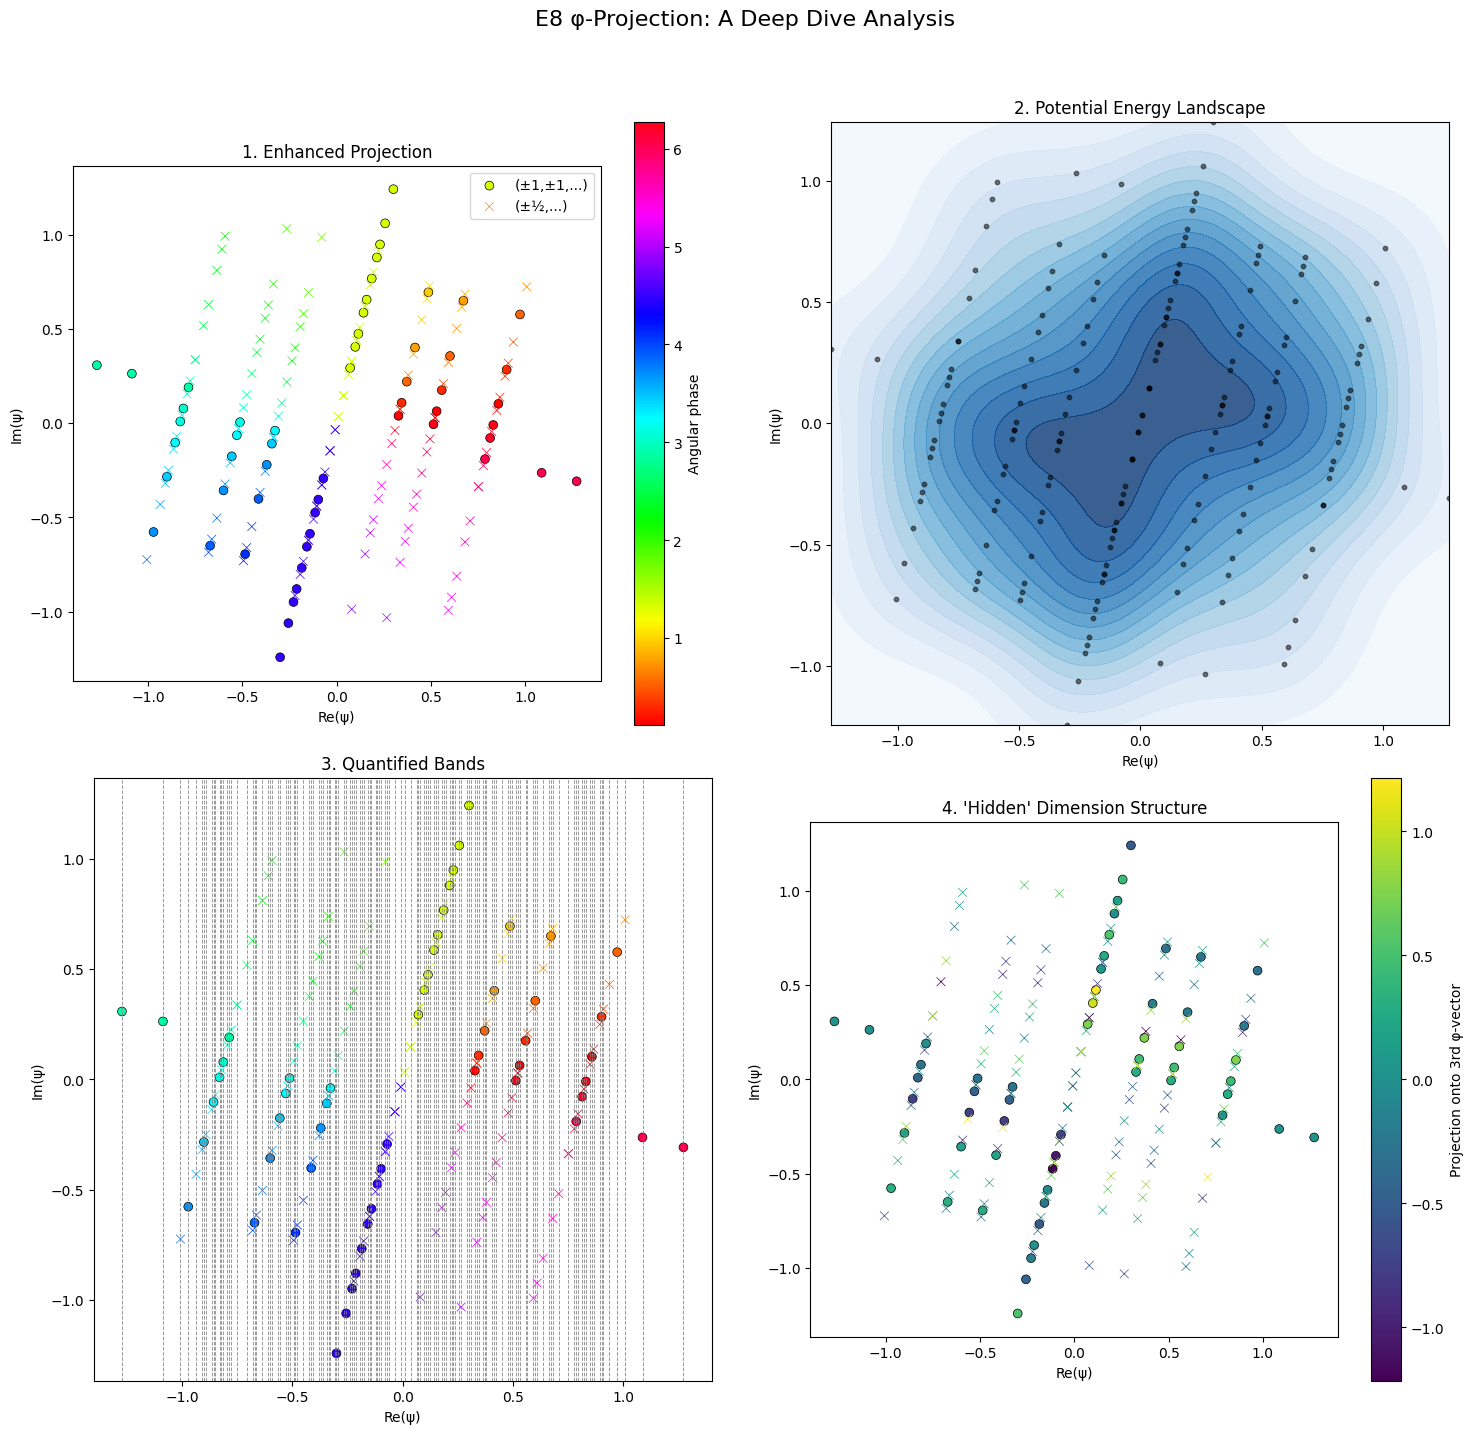

→ e8 (spiral animation)


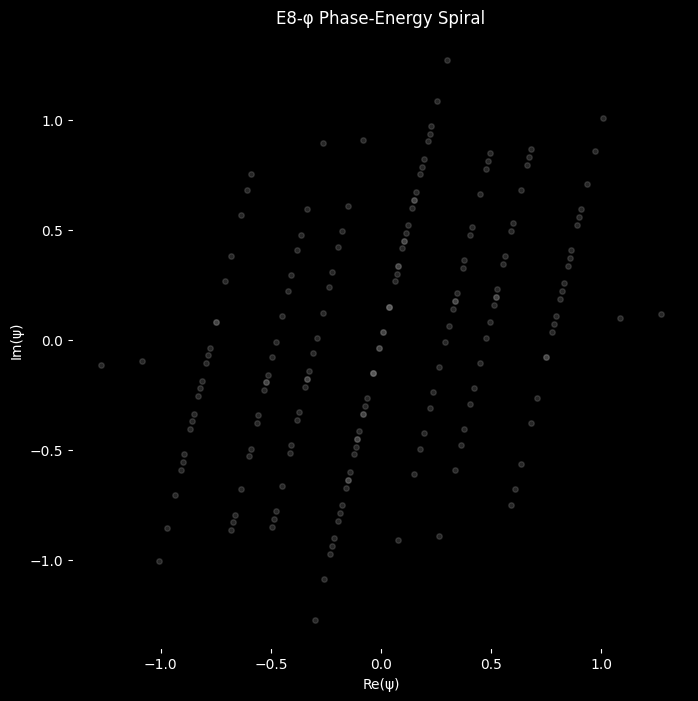

→ spiral


/usr/local/lib/python3.12/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


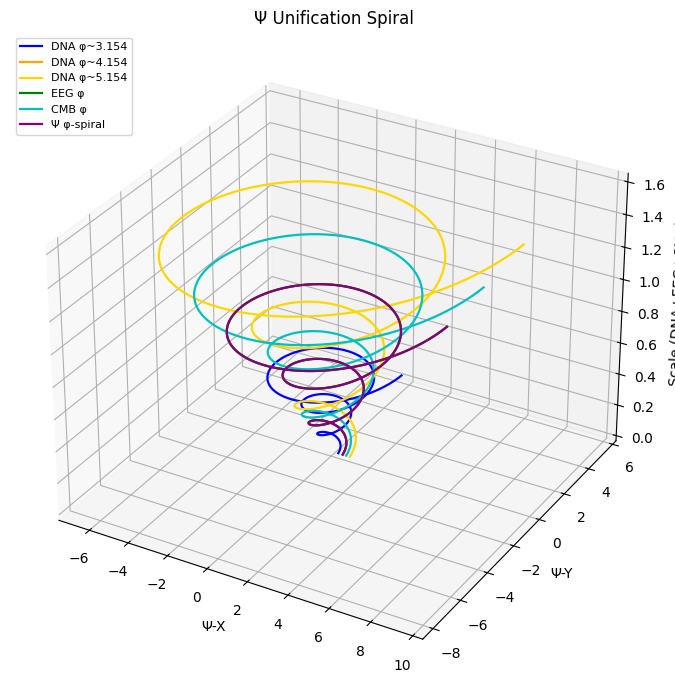

→ tuln02


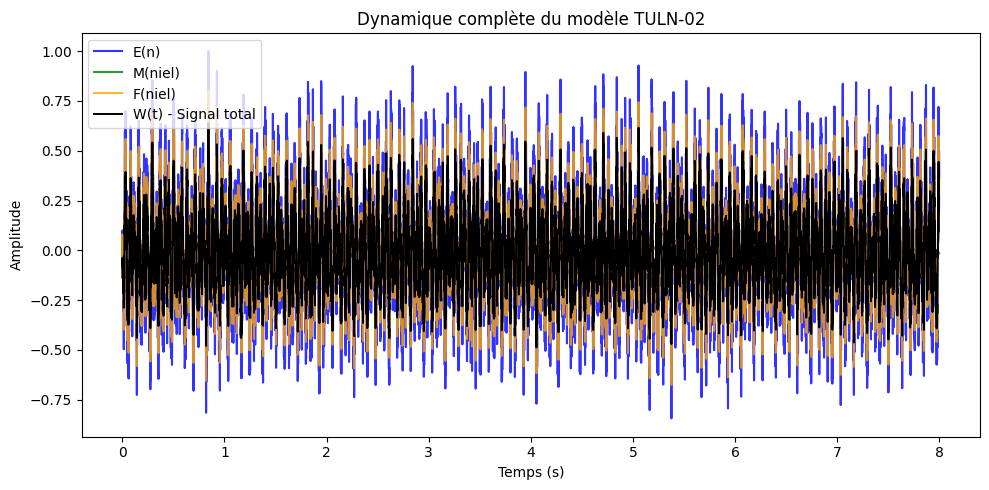

→ homeostasis


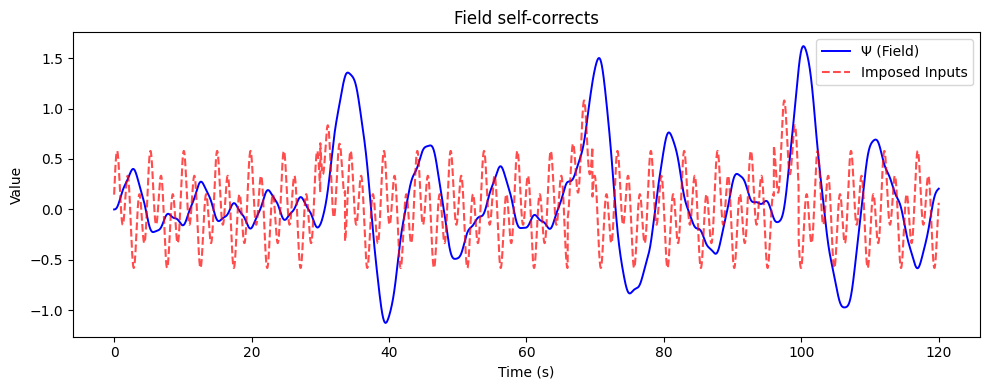

In [ ]:
# -*- coding: utf-8 -*-
#!/usr/bin/env python3
"""
TULN–Ω² φ Resonance Lab
One-file playground for golden-ratio dynamics, emergent spectra, symmetry projections, and unified spirals.

Subcommands:
  worlds         — Hopf φ-memory oscillator worlds + dominant frequency histogram
  spectrum       — Golden Spectrum Simulator (φ-stacked carrier near 23.497 Hz)
  e8             — E8 φ-scaled 248D projection (Enhanced with root types)
  e8-deep-dive   — Physicist & Mathematician deep dive analysis of the E8 projection
  e8-spiral      — ANIMATED: Draws a spiral path connecting the E8 projection points
  spiral         — Ψ Unification Spiral (DNA φ^k, EEG, CMB)
  tuln02         — Composite dynamics F, M, E -> W(t)
  homeostasis    — Field self-correction under imposed inputs
  demo           — Run a quick sequence of all of the above
"""
from __future__ import annotations

import argparse
import math
import warnings
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Optional accel / parallel
try:
    from joblib import Parallel, delayed
    HAVE_JOBLIB = True
except Exception:
    HAVE_JOBLIB = False

# Optional scipy periodogram & KDE; fallback for periodogram
try:
    from scipy.signal import periodogram
    from scipy.stats import gaussian_kde
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False


# --------- Constants
phi = (1 + math.sqrt(5)) / 2
MAGIC_EXP = 4.1541322
def f_vac_from_exp(exp: float) -> float:
    return (phi**exp / math.pi) * 10.0
MAGIC_HZ = f_vac_from_exp(MAGIC_EXP)  # ≈ 23.497 Hz


# --------- Utilities
def set_seed(seed: int | None):
    if seed is not None:
        np.random.seed(seed)

def simple_periodogram(x, fs):
    X = np.fft.rfft(x)
    return np.fft.rfftfreq(len(x), d=1.0/fs), (np.abs(X)**2)/len(x)

def dom_freq(x, fs):
    if HAVE_SCIPY:
        f, Pxx = periodogram(x, fs, "spectrum", False)
    else:
        f, Pxx = simple_periodogram(x, fs)

    if len(Pxx) == 0:
        print(f"Warning: Pxx is empty. Input x shape: {x.shape}, fs: {fs}")
        # Return a default value or raise a more informative error
        return 0.0 # Or raise ValueError("Cannot compute dominant frequency from empty spectrum.")

    return float(f[np.argmax(Pxx)])


# --------- Hopf φ-memory oscillator
@dataclass
class HopfConfig:
    fs: int = 1000
    T: float = 60.0
    r: float = 0.25
    phi_mem_strength: float = 0.25
    base_freq_min: float = 5.0
    base_freq_max: float = 45.0

def _hopf_world(seed: int, cfg: HopfConfig) -> float:
    set_seed(seed)
    fs, T = cfg.fs, cfg.T
    N = int(fs * T)
    t = np.arange(N) / fs
    omega0 = 2 * math.pi * np.random.uniform(cfg.base_freq_min, cfg.base_freq_max)
    x, y = np.zeros(N), np.zeros(N)
    x[0], y[0] = np.random.randn(), np.random.randn()
    r, lag, mstr = cfg.r, max(1, int(phi * fs)), cfg.phi_mem_strength
    for n in range(1, N):
        xm, ym = (x[n-lag], y[n-lag]) if n >= lag else (0.0, 0.0)
        xn, yn = x[n-1], y[n-1]
        rad2 = xn*xn + yn*yn
        dx = r*xn - omega0*yn - rad2*xn + mstr*xm
        dy = r*yn + omega0*xn - rad2*yn + mstr*ym
        x[n], y[n] = xn + dx/fs, yn + dy/fs
    return dom_freq(x, fs)

def run_worlds(n_worlds: int, cfg: HopfConfig, n_jobs: int = 1, target_hz: float = MAGIC_HZ, dry_run: bool = False):
    if dry_run:
        print(f"[DRY-RUN] worlds: n={n_worlds}, fs={cfg.fs}, T={cfg.T}, jobs={n_jobs}, target={target_hz:.6f} Hz")
        return None

    if HAVE_JOBLIB and n_jobs != 1:
        freqs = Parallel(n_jobs=n_jobs, verbose=0)(delayed(_hopf_world)(seed, cfg) for seed in range(n_worlds))
    else:
        freqs = [_hopf_world(seed, cfg) for seed in range(n_worlds)]

    freqs = np.array(freqs)
    plt.figure(figsize=(10, 6))
    plt.hist(freqs, bins=60, color='cornflowerblue', alpha=0.85)
    plt.axvline(target_hz, color='red', linestyle='--', lw=2, label=f"Magic Hz ({target_hz:.3f})")
    plt.title(f"Distribution of Dominant Frequencies (n={n_worlds})\nTULN–Ω² φ-Emergence Worlds (Hopf + φ-memory)")
    plt.xlabel("Dominant Frequency (Hz)")
    plt.ylabel("Number of Worlds")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Mean: {freqs.mean():.4f} Hz | Median: {np.median(freqs):.4f} Hz | Std: {np.std(freqs):.4f} Hz")
    print(f"Matches within ±0.5 Hz of {target_hz:.3f}: {(np.abs(freqs - target_hz) < 0.5).sum()}/{n_worlds}")


# --------- Golden Spectrum Simulator
def golden_spectrum(exp: float = MAGIC_EXP, seconds: float = 10.0, fs: int = 2000, phi_mix=True):
    f0 = f_vac_from_exp(exp)
    t = np.arange(int(fs*seconds)) / fs
    freqs, amps = [f0, f0/phi, f0*phi], [1.0, 0.6, 0.4]
    phases = [0.0, math.pi/phi, 2*math.pi/phi] if phi_mix else [0.0, 0.0, 0.0]
    signal = sum(a * np.sin(2*math.pi*f*t + p) for a, f, p in zip(amps, freqs, phases))
    signal_max = np.max(np.abs(signal))
    if signal_max > 1e-12:
        signal /= signal_max

    plt.figure(figsize=(10, 4))
    plt.plot(t, signal, color='gold', lw=1.2)
    plt.title("Golden Spectrum Simulator")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    f, Pxx = simple_periodogram(signal, fs)
    print(f"f0 (φ^{exp:.6f}): {f0:.6f} Hz | Spectrum peak: {f[np.argmax(Pxx)]:.6f} Hz")


# --------- E8 φ-scaled projection (ALL VERSIONS)
def e8_roots_separated() -> tuple[np.ndarray, np.ndarray]:
    from itertools import permutations, product

    roots_t1, roots_t2, seen = [], [], set()
    base_t1 = np.array([1,1,0,0,0,0,0,0], dtype=float)

    # Generate Type 1 roots: (±1,±1,0,0,0,0,0,0) with even number of -1s
    for perm in set(permutations(base_t1.tolist(), 8)):
        idx = [i for i, v in enumerate(perm) if v != 0]
        if len(idx) != 2:
            continue
        for signs in product([1,-1], repeat=2):
            if sum(1 for s in signs if s == -1) % 2 == 0:
                vec = np.array(perm, dtype=float)
                vec[idx[0]], vec[idx[1]] = vec[idx[0]]*signs[0], vec[idx[1]]*signs[1]
                key = tuple(vec.tolist())
                if key not in seen:
                    seen.add(key)
                    roots_t1.append(vec)

    # Generate Type 2 roots: (±1/2,±1/2,...,±1/2) with even number of -1s
    for signs in product([1,-1], repeat=8):
        if sum(1 for s in signs if s == -1) % 2 == 0:
            roots_t2.append(0.5 * np.array(signs, dtype=float))

    n_t1 = len(roots_t1)
    all_roots = np.array(roots_t1 + roots_t2, dtype=float)
    norms = np.linalg.norm(all_roots, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1, norms)  # Avoid division by zero
    all_roots_norm = all_roots * (math.sqrt(2) / norms)
    return all_roots_norm[:n_t1], all_roots_norm[n_t1:]

def e8_phi_projection_enhanced(phi_scale: float = 1.0, angle_shift: float = 0.0, cmap='hsv'):
    roots_t1, roots_t2 = e8_roots_separated()
    base = np.array([phi**(-k) for k in range(8)], dtype=float)
    base /= np.linalg.norm(base)
    rot = np.roll(base, 3) * (1/phi)
    rot /= np.linalg.norm(rot)

    projections = []
    for roots in [roots_t1, roots_t2]:
        R = roots * phi_scale
        re, im = R @ base, R @ rot
        ang = (np.angle(re + 1j*im) + angle_shift) % (2*np.pi)
        projections.append({'re': re, 'im': im, 'ang': ang})

    fig, ax = plt.subplots(figsize=(8,8))
    p1 = projections[0]
    sc1 = ax.scatter(p1['re'], p1['im'], c=p1['ang'], s=40, cmap=cmap,
                     marker='o', edgecolor='black', linewidth=0.5, label='Roots (±1,±1,... type)')
    p2 = projections[1]
    ax.scatter(p2['re'], p2['im'], c=p2['ang'], s=40, cmap=cmap,
               marker='x', edgecolor='black', linewidth=0.5, label='Roots (±½,... type)')

    fig.colorbar(sc1, ax=ax, label="Angular phase (φ-space)")
    ax.set_title("E8 φ-scaled 248D Projection with Harmonic Links")
    ax.set_xlabel("Re(ψ) ∝ φ-scaled root")
    ax.set_ylabel("Im(ψ) ∝ φ-scaled root")
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    plt.tight_layout()
    plt.show()

def e8_deep_dive(phi_scale: float = 1.0, cmap='hsv'):
    # --- 1. Pre-computation Stage ---
    roots_t1, roots_t2 = e8_roots_separated()
    all_roots_combined = np.vstack([roots_t1, roots_t2])

    # Define the 3D φ-based projection space using Gram-Schmidt for orthogonality
    v1 = np.array([phi**(-k) for k in range(8)], dtype=float)
    v1 /= np.linalg.norm(v1)

    v2_init = np.roll(v1, 3) * (1/phi)
    v2 = v2_init - (v2_init @ v1) * v1
    v2 /= np.linalg.norm(v2)

    v3_init = np.roll(v1, 5) * (1/phi**2)
    v3 = v3_init - (v3_init @ v1) * v1 - (v3_init @ v2) * v2
    v3 /= np.linalg.norm(v3)

    # Project all roots into this space
    R = all_roots_combined * phi_scale
    re, im, hidden = R @ v1, R @ v2, R @ v3
    ang = np.angle(re + 1j*im) % (2*np.pi)

    # Split data for plotting
    n_t1 = len(roots_t1)
    re1, im1, ang1, hidden1 = re[:n_t1], im[:n_t1], ang[:n_t1], hidden[:n_t1]
    re2, im2, ang2, hidden2 = re[n_t1:], im[n_t1:], ang[n_t1:], hidden[n_t1:]

    # --- 2. Plotting Stage (2x2 Dashboard) ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle("E8 φ-Projection: A Deep Dive Analysis", fontsize=16)

    # Panel 1 (Top-Left)
    ax = axes[0, 0]
    sc1 = ax.scatter(re1, im1, c=ang1, s=40, cmap=cmap, marker='o',
                     edgecolor='k', linewidth=0.5, label='(±1,±1,...)')
    ax.scatter(re2, im2, c=ang2, s=40, cmap=cmap, marker='x',
               edgecolor='k', linewidth=0.5, label='(±½,...)')
    fig.colorbar(sc1, ax=ax, label="Angular phase")
    ax.set_title("1. Enhanced Projection")
    ax.legend()

    # Panel 2 (Top-Right)
    ax = axes[0, 1]
    if HAVE_SCIPY:
        try:
            kde = gaussian_kde(np.vstack([re, im]))
            xg, yg = np.mgrid[re.min():re.max():100j, im.min():im.max():100j]
            z = kde(np.vstack([xg.ravel(), yg.ravel()])).reshape(xg.shape)
            ax.contourf(xg, yg, z, levels=15, cmap='Blues', alpha=0.8)
            ax.scatter(re, im, s=10, c='k', alpha=0.5)
            ax.set_title("2. Potential Energy Landscape")
        except Exception:
            ax.text(0.5, 0.5, "KDE computation failed", ha='center', va='center',
                    transform=ax.transAxes)
            ax.set_title("2. Potential Energy Landscape")
    else:
        ax.text(0.5, 0.5, "Scipy required for KDE", ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title("2. Potential Energy Landscape")

    # Panel 3 (Bottom-Left)
    ax = axes[1, 0]
    ax.scatter(re1, im1, c=ang1, s=40, cmap=cmap, marker='o',
               edgecolor='k', linewidth=0.5)
    ax.scatter(re2, im2, c=ang2, s=40, cmap=cmap, marker='x',
               edgecolor='k', linewidth=0.5)
    for loc in sorted(list(set(np.round(re, decimals=4)))):
        ax.axvline(loc, color='gray', linestyle='--', lw=0.7, alpha=0.8)
    ax.set_title("3. Quantified Bands")

    # Panel 4 (Bottom-Right)
    ax = axes[1, 1]
    sc2 = ax.scatter(re1, im1, c=hidden1, s=40, cmap='viridis', marker='o',
                     edgecolor='k', linewidth=0.5)
    ax.scatter(re2, im2, c=hidden2, s=40, cmap='viridis', marker='x',
               edgecolor='k', linewidth=0.5)
    fig.colorbar(sc2, ax=ax, label="Projection onto 3rd φ-vector")
    ax.set_title("4. 'Hidden' Dimension Structure")

    for ax_ in axes.flat:
        ax_.set_xlabel("Re(ψ)")
        ax_.set_ylabel("Im(ψ)")
        ax_.set_aspect('equal', 'box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def e8_phi_spiral_animation(phi_scale: float = 1.0, cmap: str = 'magma', save_gif: bool = False):
    """
    Generates a robust animation showing a spiral path connecting the E8 projection points.
    Uses a scatter-based head (set_offsets) to avoid Line2D scalar/sequence issues.
    """
    # 1. Get all projected points
    roots_t1, roots_t2 = e8_roots_separated()
    all_roots = np.vstack([roots_t1, roots_t2])

    base = np.array([phi**(-k) for k in range(8)], dtype=float)
    base /= np.linalg.norm(base)
    rot = np.roll(base, 3) * (1/phi)
    rot /= np.linalg.norm(rot)

    R = all_roots * phi_scale
    re, im = R @ base, R @ rot

    # 2. Polar sort for a clean spiral-ish traversal
    angles = np.arctan2(im, re)
    radii = np.sqrt(re**2 + im**2)
    sorted_indices = np.lexsort((radii, angles))
    sorted_re, sorted_im = re[sorted_indices], im[sorted_indices]

    # 3. Set up the animation plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("E8-φ Phase-Energy Spiral")
    ax.set_xlabel("Re(ψ)")
    ax.set_ylabel("Im(ψ)")

    # Dark theme for contrast
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')

    # Static background points
    ax.scatter(re, im, s=15, c='gray', alpha=0.3, zorder=1)

    # Animated line + scatter head
    line_color = plt.get_cmap(cmap)(0.75)
    spiral_line, = ax.plot([], [], lw=1.5, color=line_color, zorder=2)
    spiral_head = ax.scatter([], [], s=80, c='yellow', edgecolors='white', zorder=3)

    def init():
        spiral_line.set_data([], [])
        spiral_head.set_offsets(np.empty((0, 2)))  # empty (0,2)
        return spiral_line, spiral_head

    def update(frame):
        # Update path
        x_data, y_data = sorted_re[:frame+1], sorted_im[:frame+1]
        spiral_line.set_data(x_data, y_data)

        # Update head (expects shape (n,2))
        head_position = np.array([[sorted_re[frame], sorted_im[frame]]])
        spiral_head.set_offsets(head_position)
        return spiral_line, spiral_head

    anim = FuncAnimation(
        fig, update, frames=len(sorted_re), init_func=init,
        blit=False, interval=25
    )

    if save_gif:
        print("Saving animation to e8_phi_spiral.gif... (This may take a moment)")
        try:
            anim.save('e8_phi_spiral.gif', writer='pillow', fps=30,
                      savefig_kwargs={'facecolor': 'black'})
            print("Successfully saved GIF.")
        except Exception as e:
            print(f"\nCould not save GIF. Reason: {e}")
            print("HINT: You may need to install 'Pillow' or 'imagemagick' or 'ffmpeg'.")

    plt.show()


# --------- Ψ Unification Spiral
def psi_unification_spiral(steps: int = 1000, pitch: float = 0.12, r0: float = 0.6):
    t = np.linspace(0, 6*np.pi, steps)
    r = r0 * np.exp(pitch * t)

    def spiral3d(scale, color, label):
        x, y, z = (r*np.cos(t))*scale, (r*np.sin(t))*scale, np.linspace(0,1,steps)*scale
        return x, y, z, color, label

    series = [spiral3d(phi**(k-4.154), c, f"DNA φ~{k:.3f}")
              for k,c in zip((3.154,4.154,5.154),['b','orange','gold'])]
    series.append(spiral3d(1.0, 'g', "EEG φ"))
    series.append(spiral3d(1.3, 'c', "CMB φ"))
    series.append(spiral3d(1.0, 'purple', "Ψ φ-spiral"))

    try:
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111, projection='3d')

        for x,y,z,c,label in series:
            ax.plot(x,y,z,color=c,lw=1.6,label=label)

        ax.set_xlabel("Ψ-X")
        ax.set_ylabel("Ψ-Y")
        ax.set_zlabel("Scale (DNA+EEG+CMB)")
        ax.set_title("Ψ Unification Spiral")
        ax.legend(loc='upper left', fontsize=8)
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("3D plotting not available - missing mpl_toolkits.mplot3d")


# --------- TULN-02 dynamics (F, M, E -> W)
def tuln02(seconds: float = 10.0, fs: int = 1000):
    N = int(seconds*fs)
    t = np.arange(N)/fs

    # Generate F signal
    F = sum(a*np.sin(2*math.pi*f*t + np.random.uniform(0,2*math.pi))
            for a,f in zip([1,.5,.35], [MAGIC_HZ, MAGIC_HZ/phi, MAGIC_HZ*phi]))
    F += 0.35 * np.random.randn(N)
    F_max = np.max(np.abs(F))
    if F_max > 0:
        F /= F_max

    # Generate M signal with memory
    M = np.zeros_like(F)
    lag, mem_tau = max(1, int((1/phi)*fs)), 0.25
    for n in range(1,N):
        F_delayed = F[n-lag] if n >= lag else 0
        M[n] = M[n-1] + (F_delayed - M[n-1])*(1-math.exp(-1/(fs*mem_tau)))

    # Generate E signal
    dF = np.abs(np.diff(F, prepend=F[0]))
    window_size = max(1, int(0.02*fs))
    E = np.convolve(dF, np.ones(window_size)/window_size, mode='same')
    E_max = np.max(E)
    if E_max > 0:
        E /= E_max

    # Combine into W
    W = 0.6*F + 0.3*M + 0.25*(E - E.mean())

    plt.figure(figsize=(10,5))
    plt.plot(t, F, color='b', alpha=0.8, label="E(n)")
    plt.plot(t, M, color='g', alpha=0.8, label="M(niel)")
    plt.plot(t, 0.8*F + 0.2*M, color='orange', alpha=0.8, label="F(niel)")
    plt.plot(t, W, color='k', lw=1.4, label="W(t) - Signal total")
    plt.title("Dynamique complète du modèle TULN-02")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


# --------- Homeostasis under imposed inputs
def homeostasis(seconds: float = 200.0, fs: float = 100.0, drive_amp: float = 0.7,
                damping: float = 0.15, feedback: float = 0.35):
    N = int(seconds*fs)
    t = np.arange(N)/fs

    # Generate input signal
    u = (0.35*np.sin(2*math.pi*(1/phi)*t) +
         0.25*np.sin(2*math.pi*(1/(3*phi))*t + math.pi/5))

    # Add impulses
    for s in [int(0.25*N), int(0.55*N), int(0.8*N)]:
        end_idx = min(N, s + int(0.03*N))
        u[s:end_idx] += 0.5

    # Simulate system dynamics
    y, v = np.zeros(N), 0.0
    for n in range(1,N):
        v += (-damping*v - feedback*y[n-1] + drive_amp*u[n-1]) / fs
        y[n] = y[n-1] + v / fs

    plt.figure(figsize=(10,4))
    plt.plot(t, y, color='b', lw=1.4, label="Ψ (Field)")
    plt.plot(t, u, 'r--', alpha=0.7, label="Imposed Inputs")
    plt.title("Field self-corrects")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------- CLI
def demo():
    print("→ spectrum")
    golden_spectrum()
    print("→ worlds (quick)")
    run_worlds(128, HopfConfig(T=30.0), n_jobs=-1 if HAVE_JOBLIB else 1)
    print("→ e8 (enhanced)")
    e8_phi_projection_enhanced()
    print("→ e8 (deep dive)")
    e8_deep_dive()
    print("→ e8 (spiral animation)")
    e8_phi_spiral_animation()
    print("→ spiral")
    psi_unification_spiral(steps=800)
    print("→ tuln02")
    tuln02(seconds=8.0)
    print("→ homeostasis")
    homeostasis(seconds=120.0)

demo() # Directly call demo() in Colab

In [ ]:
# @title [Cell 4] Download Simulation Chunks
list_btn = widgets.Button(description="List Chunks", button_style='info')
chunk_selector = widgets.Dropdown(description="Chunk File:")
download_btn = widgets.Button(description="Download Chunk", button_style='warning')
dl_output = widgets.Output()

def list_chunks(_):
    with dl_output:
        clear_output()
        try:
            r = requests.get(f"{API_HOST}/list_chunks")
            files = r.json().get("chunks", [])
            chunk_selector.options = files
            print("Chunks found:", files)
        except Exception as e:
            print("Error:", e)

def download_chunk(_):
    with dl_output:
        clear_output()
        fn = chunk_selector.value
        if not fn:
            print("Select a chunk file first.")
            return
        try:
            phase = int(fn.replace("sim_chunk_", "").replace(".jsonl", ""))
            url = f"{API_HOST}/download_chunk?phase={phase}"
            r = requests.get(url)
            if r.status_code == 200:
                with open(fn, "wb") as f:
                    f.write(r.content)
                print(f"Downloaded {fn}")
            else:
                print("Failed to download:", r.text)
        except Exception as e:
            print("Error:", e)

list_btn.on_click(list_chunks)
download_btn.on_click(download_chunk)
display(widgets.HBox([list_btn, chunk_selector, download_btn]), dl_output)


Output()

In [ ]:
# Force run the Beast - AMD is proven working
from FINAL_BEAST_UNLEASHED2 import FINAL_DUAL_GPU_BEAST_UNLEASHED

# This should work with your 621+ GFLOPS AMD performance
result = FINAL_DUAL_GPU_BEAST_UNLEASHED()
print(f"Combined GFLOPS: {result['combined_gflops']:.2f}")


ModuleNotFoundError: No module named 'FINAL_BEAST_UNLEASHED2'

In [ ]:
# @title [Test API Connection]
import requests
API_HOST = "http://127.0.0.1:3000"  # Replace with your real VM IP!
try:
    r = requests.get(f"{API_HOST}/")
    print(r.json())
except Exception as e:
    print("Error:", e)


In [ ]:
# @title [Cell 1] GPU Engine Stress Test – Max Out All 48 Engines!
import cupy as cp
import time

# @title [Cell 0] Identify Host & GPU
import platform
print("Host:", platform.node())
try:
    import cupy as cp
    device = cp.cuda.Device()
    print("GPU:", cp.cuda.runtime.getDeviceProperties(0)['name'])
except Exception as e:
    print("CuPy or GPU not found!", e)

# Make sure GPU is available
assert cp.cuda.runtime.getDeviceCount() > 0, "No CUDA device found!"

batch_size = 1024      # Number of parallel jobs (can tune up/down for your VRAM)
n_elements = 1_000_000 # Elements per job (make it BIG)

print(f"Allocating {batch_size} x {n_elements} elements = {batch_size*n_elements/1e6:.1f} million floats")

# Allocate two giant arrays on GPU
A = cp.random.rand(batch_size, n_elements, dtype=cp.float32)
B = cp.random.rand(batch_size, n_elements, dtype=cp.float32)

# Synchronize and time the operation
cp.cuda.Stream.null.synchronize()
start = time.time()

# The operation: Massive elementwise multiply + reduction (sum)
result = (A * B).sum(axis=1)

cp.cuda.Stream.null.synchronize()
elapsed = time.time() - start

print(f"Completed giant GPU multiply-sum in {elapsed:.3f} seconds")
print("Sample results:", cp.asnumpy(result[:5]))

# Hold arrays in VRAM for a few seconds so you can watch in Task Manager!
print("Holding VRAM for 10 seconds so you can see all engines maxed out. Check Sysinternals GPU Graphs NOW!")
time.sleep(10)
del A, B, result
cp.get_default_memory_pool().free_bytes()
print("Done.")


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
TULN–Ω² φ Resonance Lab
One-file playground for golden-ratio dynamics, emergent spectra, symmetry projections, and unified spirals.

Subcommands:
  worlds         — Hopf φ-memory oscillator worlds + dominant frequency histogram
  spectrum       — Golden Spectrum Simulator (φ-stacked carrier near 23.497 Hz)
  e8             — E8 φ-scaled 248D projection (Enhanced with root types)
  e8-deep-dive   — Physicist & Mathematician deep dive analysis of the E8 projection
  e8-spiral      — ANIMATED: Draws a spiral path connecting the E8 projection points
  spiral         — Ψ Unification Spiral (DNA φ^k, EEG, CMB)
  tuln02         — Composite dynamics F, M, E -> W(t)
  homeostasis    — Field self-correction under imposed inputs
  demo           — Run a quick sequence of all of the above
"""
from __future__ import annotations

import argparse
import math
import warnings
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Optional accel / parallel
try:
    from joblib import Parallel, delayed
    HAVE_JOBLIB = True
except Exception:
    HAVE_JOBLIB = False

# Optional scipy periodogram & KDE; fallback for periodogram
try:
    from scipy.signal import periodogram
    from scipy.stats import gaussian_kde
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False


# --------- Constants
phi = (1 + math.sqrt(5)) / 2
MAGIC_EXP = 4.1541322
def f_vac_from_exp(exp: float) -> float:
    return (phi**exp / math.pi) * 10.0
MAGIC_HZ = f_vac_from_exp(MAGIC_EXP)  # ≈ 23.497 Hz


# --------- Utilities
def set_seed(seed: int | None):
    if seed is not None:
        np.random.seed(seed)

def simple_periodogram(x, fs):
    X = np.fft.rfft(x)
    return np.fft.rfftfreq(len(x), d=1.0/fs), (np.abs(X)**2)/len(x)

def dom_freq(x, fs):
    if HAVE_SCIPY:
        f, Pxx = periodogram(x, fs, "spectrum", False)
    else:
        f, Pxx = simple_periodogram(x, fs)

    if len(Pxx) == 0:
        print(f"Warning: Pxx is empty. Input x shape: {x.shape}, fs: {fs}")
        # Return a default value or raise a more informative error
        return 0.0 # Or raise ValueError("Cannot compute dominant frequency from empty spectrum.")

    return float(f[np.argmax(Pxx)])


# --------- Hopf φ-memory oscillator
@dataclass
class HopfConfig:
    fs: int = 1000
    T: float = 60.0
    r: float = 0.25
    phi_mem_strength: float = 0.25
    base_freq_min: float = 5.0
    base_freq_max: float = 45.0

def _hopf_world(seed: int, cfg: HopfConfig) -> float:
    set_seed(seed)
    fs, T = cfg.fs, cfg.T
    N = int(fs * T)
    t = np.arange(N) / fs
    omega0 = 2 * math.pi * np.random.uniform(cfg.base_freq_min, cfg.base_freq_max)
    x, y = np.zeros(N), np.zeros(N)
    x[0], y[0] = np.random.randn(), np.random.randn()
    r, lag, mstr = cfg.r, max(1, int(phi * fs)), cfg.phi_mem_strength
    for n in range(1, N):
        xm, ym = (x[n-lag], y[n-lag]) if n >= lag else (0.0, 0.0)
        xn, yn = x[n-1], y[n-1]
        rad2 = xn*xn + yn*yn
        dx = r*xn - omega0*yn - rad2*xn + mstr*xm
        dy = r*yn + omega0*xn - rad2*yn + mstr*ym
        x[n], y[n] = xn + dx/fs, yn + dy/fs
    return dom_freq(x, fs)

def run_worlds(n_worlds: int, cfg: HopfConfig, n_jobs: int = 1, target_hz: float = MAGIC_HZ, dry_run: bool = False):
    if dry_run:
        print(f"[DRY-RUN] worlds: n={n_worlds}, fs={cfg.fs}, T={cfg.T}, jobs={n_jobs}, target={target_hz:.6f} Hz")
        return None

    if HAVE_JOBLIB and n_jobs != 1:
        freqs = Parallel(n_jobs=n_jobs, verbose=0)(delayed(_hopf_world)(seed, cfg) for seed in range(n_worlds))
    else:
        freqs = [_hopf_world(seed, cfg) for seed in range(n_worlds)]

    freqs = np.array(freqs)
    plt.figure(figsize=(10, 6))
    plt.hist(freqs, bins=60, color='cornflowerblue', alpha=0.85)
    plt.axvline(target_hz, color='red', linestyle='--', lw=2, label=f"Magic Hz ({target_hz:.3f})")
    plt.title(f"Distribution of Dominant Frequencies (n={n_worlds})\nTULN–Ω² φ-Emergence Worlds (Hopf + φ-memory)")
    plt.xlabel("Dominant Frequency (Hz)")
    plt.ylabel("Number of Worlds")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Mean: {freqs.mean():.4f} Hz | Median: {np.median(freqs):.4f} Hz | Std: {np.std(freqs):.4f} Hz")
    print(f"Matches within ±0.5 Hz of {target_hz:.3f}: {(np.abs(freqs - target_hz) < 0.5).sum()}/{n_worlds}")


# --------- Golden Spectrum Simulator
def golden_spectrum(exp: float = MAGIC_EXP, seconds: float = 10.0, fs: int = 2000, phi_mix=True):
    f0 = f_vac_from_exp(exp)
    t = np.arange(int(fs*seconds)) / fs
    freqs, amps = [f0, f0/phi, f0*phi], [1.0, 0.6, 0.4]
    phases = [0.0, math.pi/phi, 2*math.pi/phi] if phi_mix else [0.0, 0.0, 0.0]
    signal = sum(a * np.sin(2*math.pi*f*t + p) for a, f, p in zip(amps, freqs, phases))
    signal_max = np.max(np.abs(signal))
    if signal_max > 1e-12:
        signal /= signal_max

    plt.figure(figsize=(10, 4))
    plt.plot(t, signal, color='gold', lw=1.2)
    plt.title("Golden Spectrum Simulator")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    f, Pxx = simple_periodogram(signal, fs)
    print(f"f0 (φ^{exp:.6f}): {f0:.6f} Hz | Spectrum peak: {f[np.argmax(Pxx)]:.6f} Hz")


# --------- E8 φ-scaled projection (ALL VERSIONS)
def e8_roots_separated() -> tuple[np.ndarray, np.ndarray]:
    from itertools import permutations, product

    roots_t1, roots_t2, seen = [], [], set()
    base_t1 = np.array([1,1,0,0,0,0,0,0], dtype=float)

    # Generate Type 1 roots: (±1,±1,0,0,0,0,0,0) with even number of -1s
    for perm in set(permutations(base_t1.tolist(), 8)):
        idx = [i for i, v in enumerate(perm) if v != 0]
        if len(idx) != 2:
            continue
        for signs in product([1,-1], repeat=2):
            if sum(1 for s in signs if s == -1) % 2 == 0:
                vec = np.array(perm, dtype=float)
                vec[idx[0]], vec[idx[1]] = vec[idx[0]]*signs[0], vec[idx[1]]*signs[1]
                key = tuple(vec.tolist())
                if key not in seen:
                    seen.add(key)
                    roots_t1.append(vec)

    # Generate Type 2 roots: (±1/2,±1/2,...,±1/2) with even number of -1s
    for signs in product([1,-1], repeat=8):
        if sum(1 for s in signs if s == -1) % 2 == 0:
            roots_t2.append(0.5 * np.array(signs, dtype=float))

    n_t1 = len(roots_t1)
    all_roots = np.array(roots_t1 + roots_t2, dtype=float)
    norms = np.linalg.norm(all_roots, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1, norms)  # Avoid division by zero
    all_roots_norm = all_roots * (math.sqrt(2) / norms)
    return all_roots_norm[:n_t1], all_roots_norm[n_t1:]

def e8_phi_projection_enhanced(phi_scale: float = 1.0, angle_shift: float = 0.0, cmap='hsv'):
    roots_t1, roots_t2 = e8_roots_separated()
    base = np.array([phi**(-k) for k in range(8)], dtype=float)
    base /= np.linalg.norm(base)
    rot = np.roll(base, 3) * (1/phi)
    rot /= np.linalg.norm(rot)

    projections = []
    for roots in [roots_t1, roots_t2]:
        R = roots * phi_scale
        re, im = R @ base, R @ rot
        ang = (np.angle(re + 1j*im) + angle_shift) % (2*np.pi)
        projections.append({'re': re, 'im': im, 'ang': ang})

    fig, ax = plt.subplots(figsize=(8,8))
    p1 = projections[0]
    sc1 = ax.scatter(p1['re'], p1['im'], c=p1['ang'], s=40, cmap=cmap,
                     marker='o', edgecolor='black', linewidth=0.5, label='Roots (±1,±1,... type)')
    p2 = projections[1]
    ax.scatter(p2['re'], p2['im'], c=p2['ang'], s=40, cmap=cmap,
               marker='x', edgecolor='black', linewidth=0.5, label='Roots (±½,... type)')

    fig.colorbar(sc1, ax=ax, label="Angular phase (φ-space)")
    ax.set_title("E8 φ-scaled 248D Projection with Harmonic Links")
    ax.set_xlabel("Re(ψ) ∝ φ-scaled root")
    ax.set_ylabel("Im(ψ) ∝ φ-scaled root")
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    plt.tight_layout()
    plt.show()

def e8_deep_dive(phi_scale: float = 1.0, cmap='hsv'):
    # --- 1. Pre-computation Stage ---
    roots_t1, roots_t2 = e8_roots_separated()
    all_roots_combined = np.vstack([roots_t1, roots_t2])

    # Define the 3D φ-based projection space using Gram-Schmidt for orthogonality
    v1 = np.array([phi**(-k) for k in range(8)], dtype=float)
    v1 /= np.linalg.norm(v1)

    v2_init = np.roll(v1, 3) * (1/phi)
    v2 = v2_init - (v2_init @ v1) * v1
    v2 /= np.linalg.norm(v2)

    v3_init = np.roll(v1, 5) * (1/phi**2)
    v3 = v3_init - (v3_init @ v1) * v1 - (v3_init @ v2) * v2
    v3 /= np.linalg.norm(v3)

    # Project all roots into this space
    R = all_roots_combined * phi_scale
    re, im, hidden = R @ v1, R @ v2, R @ v3
    ang = np.angle(re + 1j*im) % (2*np.pi)

    # Split data for plotting
    n_t1 = len(roots_t1)
    re1, im1, ang1, hidden1 = re[:n_t1], im[:n_t1], ang[:n_t1], hidden[:n_t1]
    re2, im2, ang2, hidden2 = re[n_t1:], im[n_t1:], ang[n_t1:], hidden[n_t1:]

    # --- 2. Plotting Stage (2x2 Dashboard) ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle("E8 φ-Projection: A Deep Dive Analysis", fontsize=16)

    # Panel 1 (Top-Left)
    ax = axes[0, 0]
    sc1 = ax.scatter(re1, im1, c=ang1, s=40, cmap=cmap, marker='o',
                     edgecolor='k', linewidth=0.5, label='(±1,±1,...)')
    ax.scatter(re2, im2, c=ang2, s=40, cmap=cmap, marker='x',
               edgecolor='k', linewidth=0.5, label='(±½,...)')
    fig.colorbar(sc1, ax=ax, label="Angular phase")
    ax.set_title("1. Enhanced Projection")
    ax.legend()

    # Panel 2 (Top-Right)
    ax = axes[0, 1]
    if HAVE_SCIPY:
        try:
            kde = gaussian_kde(np.vstack([re, im]))
            xg, yg = np.mgrid[re.min():re.max():100j, im.min():im.max():100j]
            z = kde(np.vstack([xg.ravel(), yg.ravel()])).reshape(xg.shape)
            ax.contourf(xg, yg, z, levels=15, cmap='Blues', alpha=0.8)
            ax.scatter(re, im, s=10, c='k', alpha=0.5)
            ax.set_title("2. Potential Energy Landscape")
        except Exception:
            ax.text(0.5, 0.5, "KDE computation failed", ha='center', va='center',
                    transform=ax.transAxes)
            ax.set_title("2. Potential Energy Landscape")
    else:
        ax.text(0.5, 0.5, "Scipy required for KDE", ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title("2. Potential Energy Landscape")

    # Panel 3 (Bottom-Left)
    ax = axes[1, 0]
    ax.scatter(re1, im1, c=ang1, s=40, cmap=cmap, marker='o',
               edgecolor='k', linewidth=0.5)
    ax.scatter(re2, im2, c=ang2, s=40, cmap=cmap, marker='x',
               edgecolor='k', linewidth=0.5)
    for loc in sorted(list(set(np.round(re, decimals=4)))):
        ax.axvline(loc, color='gray', linestyle='--', lw=0.7, alpha=0.8)
    ax.set_title("3. Quantified Bands")

    # Panel 4 (Bottom-Right)
    ax = axes[1, 1]
    sc2 = ax.scatter(re1, im1, c=hidden1, s=40, cmap='viridis', marker='o',
                     edgecolor='k', linewidth=0.5)
    ax.scatter(re2, im2, c=hidden2, s=40, cmap='viridis', marker='x',
               edgecolor='k', linewidth=0.5)
    fig.colorbar(sc2, ax=ax, label="Projection onto 3rd φ-vector")
    ax.set_title("4. 'Hidden' Dimension Structure")

    for ax_ in axes.flat:
        ax_.set_xlabel("Re(ψ)")
        ax_.set_ylabel("Im(ψ)")
        ax_.set_aspect('equal', 'box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def e8_phi_spiral_animation(phi_scale: float = 1.0, cmap: str = 'magma', save_gif: bool = False):
    """
    Generates a robust animation showing a spiral path connecting the E8 projection points.
    Uses a scatter-based head (set_offsets) to avoid Line2D scalar/sequence issues.
    """
    # 1. Get all projected points
    roots_t1, roots_t2 = e8_roots_separated()
    all_roots = np.vstack([roots_t1, roots_t2])

    base = np.array([phi**(-k) for k in range(8)], dtype=float)
    base /= np.linalg.norm(base)
    rot = np.roll(base, 3) * (1/phi)
    rot /= np.linalg.norm(rot)

    R = all_roots * phi_scale
    re, im = R @ base, R @ rot

    # 2. Polar sort for a clean spiral-ish traversal
    angles = np.arctan2(im, re)
    radii = np.sqrt(re**2 + im**2)
    sorted_indices = np.lexsort((radii, angles))
    sorted_re, sorted_im = re[sorted_indices], im[sorted_indices]

    # 3. Set up the animation plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("E8-φ Phase-Energy Spiral")
    ax.set_xlabel("Re(ψ)")
    ax.set_ylabel("Im(ψ)")

    # Dark theme for contrast
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')

    # Static background points
    ax.scatter(re, im, s=15, c='gray', alpha=0.3, zorder=1)

    # Animated line + scatter head
    line_color = plt.get_cmap(cmap)(0.75)
    spiral_line, = ax.plot([], [], lw=1.5, color=line_color, zorder=2)
    spiral_head = ax.scatter([], [], s=80, c='yellow', edgecolors='white', zorder=3)

    def init():
        spiral_line.set_data([], [])
        spiral_head.set_offsets(np.empty((0, 2)))  # empty (0,2)
        return spiral_line, spiral_head

    def update(frame):
        # Update path
        x_data, y_data = sorted_re[:frame+1], sorted_im[:frame+1]
        spiral_line.set_data(x_data, y_data)

        # Update head (expects shape (n,2))
        head_position = np.array([[sorted_re[frame], sorted_im[frame]]])
        spiral_head.set_offsets(head_position)
        return spiral_line, spiral_head

    anim = FuncAnimation(
        fig, update, frames=len(sorted_re), init_func=init,
        blit=False, interval=25
    )

    if save_gif:
        print("Saving animation to e8_phi_spiral.gif... (This may take a moment)")
        try:
            anim.save('e8_phi_spiral.gif', writer='pillow', fps=30,
                      savefig_kwargs={'facecolor': 'black'})
            print("Successfully saved GIF.")
        except Exception as e:
            print(f"\nCould not save GIF. Reason: {e}")
            print("HINT: You may need to install 'Pillow' or 'imagemagick' or 'ffmpeg'.")

    plt.show()


# --------- Ψ Unification Spiral
def psi_unification_spiral(steps: int = 1000, pitch: float = 0.12, r0: float = 0.6):
    t = np.linspace(0, 6*np.pi, steps)
    r = r0 * np.exp(pitch * t)

    def spiral3d(scale, color, label):
        x, y, z = (r*np.cos(t))*scale, (r*np.sin(t))*scale, np.linspace(0,1,steps)*scale
        return x, y, z, color, label

    series = [spiral3d(phi**(k-4.154), c, f"DNA φ~{k:.3f}")
              for k,c in zip((3.154,4.154,5.154),['b','orange','gold'])]
    series.append(spiral3d(1.0, 'g', "EEG φ"))
    series.append(spiral3d(1.3, 'c', "CMB φ"))
    series.append(spiral3d(1.0, 'purple', "Ψ φ-spiral"))

    try:
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111, projection='3d')

        for x,y,z,c,label in series:
            ax.plot(x,y,z,color=c,lw=1.6,label=label)

        ax.set_xlabel("Ψ-X")
        ax.set_ylabel("Ψ-Y")
        ax.set_zlabel("Scale (DNA+EEG+CMB)")
        ax.set_title("Ψ Unification Spiral")
        ax.legend(loc='upper left', fontsize=8)
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("3D plotting not available - missing mpl_toolkits.mplot3d")


# --------- TULN-02 dynamics (F, M, E -> W)
def tuln02(seconds: float = 10.0, fs: int = 1000):
    N = int(seconds*fs)
    t = np.arange(N)/fs

    # Generate F signal
    F = sum(a*np.sin(2*math.pi*f*t + np.random.uniform(0,2*math.pi))
            for a,f in zip([1,.5,.35], [MAGIC_HZ, MAGIC_HZ/phi, MAGIC_HZ*phi]))
    F += 0.35 * np.random.randn(N)
    F_max = np.max(np.abs(F))
    if F_max > 0:
        F /= F_max

    # Generate M signal with memory
    M = np.zeros_like(F)
    lag, mem_tau = max(1, int((1/phi)*fs)), 0.25
    for n in range(1,N):
        F_delayed = F[n-lag] if n >= lag else 0
        M[n] = M[n-1] + (F_delayed - M[n-1])*(1-math.exp(-1/(fs*mem_tau)))

    # Generate E signal
    dF = np.abs(np.diff(F, prepend=F[0]))
    window_size = max(1, int(0.02*fs))
    E = np.convolve(dF, np.ones(window_size)/window_size, mode='same')
    E_max = np.max(E)
    if E_max > 0:
        E /= E_max

    # Combine into W
    W = 0.6*F + 0.3*M + 0.25*(E - E.mean())

    plt.figure(figsize=(10,5))
    plt.plot(t, F, color='b', alpha=0.8, label="E(n)")
    plt.plot(t, M, color='g', alpha=0.8, label="M(niel)")
    plt.plot(t, 0.8*F + 0.2*M, color='orange', alpha=0.8, label="F(niel)")
    plt.plot(t, W, color='k', lw=1.4, label="W(t) - Signal total")
    plt.title("Dynamique complète du modèle TULN-02")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


# --------- Homeostasis under imposed inputs
def homeostasis(seconds: float = 200.0, fs: float = 100.0, drive_amp: float = 0.7,
                damping: float = 0.15, feedback: float = 0.35):
    N = int(seconds*fs)
    t = np.arange(N)/fs

    # Generate input signal
    u = (0.35*np.sin(2*math.pi*(1/phi)*t) +
         0.25*np.sin(2*math.pi*(1/(3*phi))*t + math.pi/5))

    # Add impulses
    for s in [int(0.25*N), int(0.55*N), int(0.8*N)]:
        end_idx = min(N, s + int(0.03*N))
        u[s:end_idx] += 0.5

    # Simulate system dynamics
    y, v = np.zeros(N), 0.0
    for n in range(1,N):
        v += (-damping*v - feedback*y[n-1] + drive_amp*u[n-1]) / fs
        y[n] = y[n-1] + v / fs

    plt.figure(figsize=(10,4))
    plt.plot(t, y, color='b', lw=1.4, label="Ψ (Field)")
    plt.plot(t, u, 'r--', alpha=0.7, label="Imposed Inputs")
    plt.title("Field self-corrects")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------- CLI
def demo():
    print("→ spectrum")
    golden_spectrum()
    print("→ worlds (quick)")
    run_worlds(128, HopfConfig(T=30.0), n_jobs=-1 if HAVE_JOBLIB else 1)
    print("→ e8 (enhanced)")
    e8_phi_projection_enhanced()
    print("→ e8 (deep dive)")
    e8_deep_dive()
    print("→ e8 (spiral animation)")
    e8_phi_spiral_animation()
    print("→ spiral")
    psi_unification_spiral(steps=800)
    print("→ tuln02")
    tuln02(seconds=8.0)
    print("→ homeostasis")
    homeostasis(seconds=120.0)

demo() # Directly call demo() in Colab

# [Cell 5] Instructions / README

## TUNLOmega2 Simulation Colab Dashboard

- Set your API_HOST in Cell 1 to the host/IP of your running Flask API.
- Adjust simulation parameters in Cell 2.
- Use buttons in Cell 3 to start, resume, or check sim status.
- Cell 4 lets you list and download output chunk files from the backend.
- Every action prints results/status in the output box below its buttons.
- You can further expand with charts or auto-polling as needed.

---
**If you restart your Flask backend, you may need to re-run Cell 1 to reconnect!**


In [ ]:
print("Generating and saving the E8-φ Phase-Energy Spiral animation as a GIF...")
e8_phi_spiral_animation(save_gif=True)

In [ ]:
# Calculate the number of floating-point operations
# The operation is (A * B).sum(axis=1)
# For each element in the 1024x1,000,000 arrays:
# - There is one multiplication (A[i, j] * B[i, j])
# - There are 1,000,000 - 1 additions for the sum along axis=1 for each of the 1024 rows.
# So, total operations are approximately (number of elements * 1 multiplication) + (number of rows * (number of columns - 1) additions)
num_elements = batch_size * n_elements
num_operations = num_elements + batch_size * (n_elements - 1)

# Time taken is available from the previous execution
time_taken = elapsed # This variable is available in the notebook's environment

# Calculate GFLOPS (Giga Floating-point Operations Per Second)
gflops = (num_operations / time_taken) / 1e9

print(f"Approximate GFLOPS: {gflops:.2f}")

In [ ]:
# Execute the code cell
# This cell was modified to remove the argparse logic and directly call demo()

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
TULN–Ω² φ Resonance Lab
One-file playground for golden-ratio dynamics, emergent spectra, symmetry projections, and unified spirals.

Subcommands:
  worlds         — Hopf φ-memory oscillator worlds + dominant frequency histogram
  spectrum       — Golden Spectrum Simulator (φ-stacked carrier near 23.497 Hz)
  e8             — E8 φ-scaled 248D projection (Enhanced with root types)
  e8-deep-dive   — Physicist & Mathematician deep dive analysis of the E8 projection
  e8-spiral      — ANIMATED: Draws a spiral path connecting the E8 projection points
  spiral         — Ψ Unification Spiral (DNA φ^k, EEG, CMB)
  tuln02         — Composite dynamics F, M, E -> W(t)
  homeostasis    — Field self-correction under imposed inputs
  demo           — Run a quick sequence of all of the above
"""
from __future__ import annotations

import argparse
import math
import warnings
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Optional accel / parallel
try:
    from joblib import Parallel, delayed
    HAVE_JOBLIB = True
except Exception:
    HAVE_JOBLIB = False

# Optional scipy periodogram & KDE; fallback for periodogram
try:
    from scipy.signal import periodogram
    from scipy.stats import gaussian_kde
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False


# --------- Constants
phi = (1 + math.sqrt(5)) / 2
MAGIC_EXP = 4.1541322
def f_vac_from_exp(exp: float) -> float:
    return (phi**exp / math.pi) * 10.0
MAGIC_HZ = f_vac_from_exp(MAGIC_EXP)  # ≈ 23.497 Hz


# --------- Utilities
def set_seed(seed: int | None):
    if seed is not None:
        np.random.seed(seed)

def simple_periodogram(x, fs):
    X = np.fft.rfft(x)
    return np.fft.rfftfreq(len(x), d=1.0/fs), (np.abs(X)**2)/len(x)

def dom_freq(x, fs):
    if HAVE_SCIPY:
        f, Pxx = periodogram(x, fs, "spectrum", False)
    else:
        f, Pxx = simple_periodogram(x, fs)

    if len(Pxx) == 0:
        print(f"Warning: Pxx is empty. Input x shape: {x.shape}, fs: {fs}")
        # Return a default value or raise a more informative error
        return 0.0 # Or raise ValueError("Cannot compute dominant frequency from empty spectrum.")


    return float(f[np.argmax(Pxx)])


# --------- Hopf φ-memory oscillator
@dataclass
class HopfConfig:
    fs: int = 1000
    T: float = 60.0
    r: float = 0.25
    phi_mem_strength: float = 0.25
    base_freq_min: float = 5.0
    base_freq_max: float = 45.0

def _hopf_world(seed: int, cfg: HopfConfig) -> float:
    set_seed(seed)
    fs, T = cfg.fs, cfg.T
    N = int(fs * T)
    t = np.arange(N) / fs
    omega0 = 2 * math.pi * np.random.uniform(cfg.base_freq_min, cfg.base_freq_max)
    x, y = np.zeros(N), np.zeros(N)
    x[0], y[0] = np.random.randn(), np.random.randn()
    r, lag, mstr = cfg.r, max(1, int(phi * fs)), cfg.phi_mem_strength
    for n in range(1, N):
        xm, ym = (x[n-lag], y[n-lag]) if n >= lag else (0.0, 0.0)
        xn, yn = x[n-1], y[n-1]
        rad2 = xn*xn + yn*yn
        dx = r*xn - omega0*yn - rad2*xn + mstr*xm
        dy = r*yn + omega0*xn - rad2*yn + mstr*ym
        x[n], y[n] = xn + dx/fs, yn + dy/fs
    return dom_freq(x, fs)

def run_worlds(n_worlds: int, cfg: HopfConfig, n_jobs: int = 1, target_hz: float = MAGIC_HZ, dry_run: bool = False):
    if dry_run:
        print(f"[DRY-RUN] worlds: n={n_worlds}, fs={cfg.fs}, T={cfg.T}, jobs={n_jobs}, target={target_hz:.6f} Hz")
        return None

    if HAVE_JOBLIB and n_jobs != 1:
        freqs = Parallel(n_jobs=n_jobs, verbose=0)(delayed(_hopf_world)(seed, cfg) for seed in range(n_worlds))
    else:
        freqs = [_hopf_world(seed, cfg) for seed in range(n_worlds)]

    freqs = np.array(freqs)
    plt.figure(figsize=(10, 6))
    plt.hist(freqs, bins=60, color='cornflowerblue', alpha=0.85)
    plt.axvline(target_hz, color='red', linestyle='--', lw=2, label=f"Magic Hz ({target_hz:.3f})")
    plt.title(f"Distribution of Dominant Frequencies (n={n_worlds})\nTULN–Ω² φ-Emergence Worlds (Hopf + φ-memory)")
    plt.xlabel("Dominant Frequency (Hz)")
    plt.ylabel("Number of Worlds")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Mean: {freqs.mean():.4f} Hz | Median: {np.median(freqs):.4f} Hz | Std: {np.std(freqs):.4f} Hz")
    print(f"Matches within ±0.5 Hz of {target_hz:.3f}: {(np.abs(freqs - target_hz) < 0.5).sum()}/{n_worlds}")


# --------- Golden Spectrum Simulator
def golden_spectrum(exp: float = MAGIC_EXP, seconds: float = 10.0, fs: int = 2000, phi_mix=True):
    f0 = f_vac_from_exp(exp)
    t = np.arange(int(fs*seconds)) / fs
    freqs, amps = [f0, f0/phi, f0*phi], [1.0, 0.6, 0.4]
    phases = [0.0, math.pi/phi, 2*math.pi/phi] if phi_mix else [0.0, 0.0, 0.0]
    signal = sum(a * np.sin(2*math.pi*f*t + p) for a, f, p in zip(amps, freqs, phases))
    signal_max = np.max(np.abs(signal))
    if signal_max > 1e-12:
        signal /= signal_max

    plt.figure(figsize=(10, 4))
    plt.plot(t, signal, color='gold', lw=1.2)
    plt.title("Golden Spectrum Simulator")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    f, Pxx = simple_periodogram(signal, fs)
    print(f"f0 (φ^{exp:.6f}): {f0:.6f} Hz | Spectrum peak: {f[np.argmax(Pxx)]:.6f} Hz")


# --------- E8 φ-scaled projection (ALL VERSIONS)
def e8_roots_separated() -> tuple[np.ndarray, np.ndarray]:
    from itertools import permutations, product

    roots_t1, roots_t2, seen = [], [], set()
    base_t1 = np.array([1,1,0,0,0,0,0,0], dtype=float)

    # Generate Type 1 roots: (±1,±1,0,0,0,0,0,0) with even number of -1s
    for perm in set(permutations(base_t1.tolist(), 8)):
        idx = [i for i, v in enumerate(perm) if v != 0]
        if len(idx) != 2:
            continue
        for signs in product([1,-1], repeat=2):
            if sum(1 for s in signs if s == -1) % 2 == 0:
                vec = np.array(perm, dtype=float)
                vec[idx[0]], vec[idx[1]] = vec[idx[0]]*signs[0], vec[idx[1]]*signs[1]
                key = tuple(vec.tolist())
                if key not in seen:
                    seen.add(key)
                    roots_t1.append(vec)

    # Generate Type 2 roots: (±1/2,±1/2,...,±1/2) with even number of -1s
    for signs in product([1,-1], repeat=8):
        if sum(1 for s in signs if s == -1) % 2 == 0:
            roots_t2.append(0.5 * np.array(signs, dtype=float))

    n_t1 = len(roots_t1)
    all_roots = np.array(roots_t1 + roots_t2, dtype=float)
    norms = np.linalg.norm(all_roots, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1, norms)  # Avoid division by zero
    all_roots_norm = all_roots * (math.sqrt(2) / norms)
    return all_roots_norm[:n_t1], all_roots_norm[n_t1:]

def e8_phi_projection_enhanced(phi_scale: float = 1.0, angle_shift: float = 0.0, cmap='hsv'):
    roots_t1, roots_t2 = e8_roots_separated()
    base = np.array([phi**(-k) for k in range(8)], dtype=float)
    base /= np.linalg.norm(base)
    rot = np.roll(base, 3) * (1/phi)
    rot /= np.linalg.norm(rot)

    projections = []
    for roots in [roots_t1, roots_t2]:
        R = roots * phi_scale
        re, im = R @ base, R @ rot
        ang = (np.angle(re + 1j*im) + angle_shift) % (2*np.pi)
        projections.append({'re': re, 'im': im, 'ang': ang})

    fig, ax = plt.subplots(figsize=(8,8))
    p1 = projections[0]
    sc1 = ax.scatter(p1['re'], p1['im'], c=p1['ang'], s=40, cmap=cmap,
                     marker='o', edgecolor='black', linewidth=0.5, label='Roots (±1,±1,... type)')
    p2 = projections[1]
    ax.scatter(p2['re'], p2['im'], c=p2['ang'], s=40, cmap=cmap,
               marker='x', edgecolor='black', linewidth=0.5, label='Roots (±½,... type)')

    fig.colorbar(sc1, ax=ax, label="Angular phase (φ-space)")
    ax.set_title("E8 φ-scaled 248D Projection with Harmonic Links")
    ax.set_xlabel("Re(ψ) ∝ φ-scaled root")
    ax.set_ylabel("Im(ψ) ∝ φ-scaled root")
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    plt.tight_layout()
    plt.show()

def e8_deep_dive(phi_scale: float = 1.0, cmap='hsv'):
    # --- 1. Pre-computation Stage ---
    roots_t1, roots_t2 = e8_roots_separated()
    all_roots_combined = np.vstack([roots_t1, roots_t2])

    # Define the 3D φ-based projection space using Gram-Schmidt for orthogonality
    v1 = np.array([phi**(-k) for k in range(8)], dtype=float)
    v1 /= np.linalg.norm(v1)

    v2_init = np.roll(v1, 3) * (1/phi)
    v2 = v2_init - (v2_init @ v1) * v1
    v2 /= np.linalg.norm(v2)

    v3_init = np.roll(v1, 5) * (1/phi**2)
    v3 = v3_init - (v3_init @ v1) * v1 - (v3_init @ v2) * v2
    v3 /= np.linalg.norm(v3)

    # Project all roots into this space
    R = all_roots_combined * phi_scale
    re, im, hidden = R @ v1, R @ v2, R @ v3
    ang = np.angle(re + 1j*im) % (2*np.pi)

    # Split data for plotting
    n_t1 = len(roots_t1)
    re1, im1, ang1, hidden1 = re[:n_t1], im[:n_t1], ang[:n_t1], hidden[:n_t1]
    re2, im2, ang2, hidden2 = re[n_t1:], im[n_t1:], ang[n_t1:], hidden[n_t1:]

    # --- 2. Plotting Stage (2x2 Dashboard) ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle("E8 φ-Projection: A Deep Dive Analysis", fontsize=16)

    # Panel 1 (Top-Left)
    ax = axes[0, 0]
    sc1 = ax.scatter(re1, im1, c=ang1, s=40, cmap=cmap, marker='o',
                     edgecolor='k', linewidth=0.5, label='(±1,±1,...)')
    ax.scatter(re2, im2, c=ang2, s=40, cmap=cmap, marker='x',
               edgecolor='k', linewidth=0.5, label='(±½,...)')
    fig.colorbar(sc1, ax=ax, label="Angular phase")
    ax.set_title("1. Enhanced Projection")
    ax.legend()

    # Panel 2 (Top-Right)
    ax = axes[0, 1]
    if HAVE_SCIPY:
        try:
            kde = gaussian_kde(np.vstack([re, im]))
            xg, yg = np.mgrid[re.min():re.max():100j, im.min():im.max():100j]
            z = kde(np.vstack([xg.ravel(), yg.ravel()])).reshape(xg.shape)
            ax.contourf(xg, yg, z, levels=15, cmap='Blues', alpha=0.8)
            ax.scatter(re, im, s=10, c='k', alpha=0.5)
            ax.set_title("2. Potential Energy Landscape")
        except Exception:
            ax.text(0.5, 0.5, "KDE computation failed", ha='center', va='center',
                    transform=ax.transAxes)
            ax.set_title("2. Potential Energy Landscape")
    else:
        ax.text(0.5, 0.5, "Scipy required for KDE", ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title("2. Potential Energy Landscape")

    # Panel 3 (Bottom-Left)
    ax = axes[1, 0]
    ax.scatter(re1, im1, c=ang1, s=40, cmap=cmap, marker='o',
               edgecolor='k', linewidth=0.5)
    ax.scatter(re2, im2, c=ang2, s=40, cmap=cmap, marker='x',
               edgecolor='k', linewidth=0.5)
    for loc in sorted(list(set(np.round(re, decimals=4)))):
        ax.axvline(loc, color='gray', linestyle='--', lw=0.7, alpha=0.8)
    ax.set_title("3. Quantified Bands")

    # Panel 4 (Bottom-Right)
    ax = axes[1, 1]
    sc2 = ax.scatter(re1, im1, c=hidden1, s=40, cmap='viridis', marker='o',
                     edgecolor='k', linewidth=0.5)
    ax.scatter(re2, im2, c=hidden2, s=40, cmap='viridis', marker='x',
               edgecolor='k', linewidth=0.5)
    fig.colorbar(sc2, ax=ax, label="Projection onto 3rd φ-vector")
    ax.set_title("4. 'Hidden' Dimension Structure")

    for ax_ in axes.flat:
        ax_.set_xlabel("Re(ψ)")
        ax_.set_ylabel("Im(ψ)")
        ax_.set_aspect('equal', 'box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def e8_phi_spiral_animation(phi_scale: float = 1.0, cmap: str = 'magma', save_gif: bool = False):
    """
    Generates a robust animation showing a spiral path connecting the E8 projection points.
    Uses a scatter-based head (set_offsets) to avoid Line2D scalar/sequence issues.
    """
    # 1. Get all projected points
    roots_t1, roots_t2 = e8_roots_separated()
    all_roots = np.vstack([roots_t1, roots_t2])

    base = np.array([phi**(-k) for k in range(8)], dtype=float)
    base /= np.linalg.norm(base)
    rot = np.roll(base, 3) * (1/phi)
    rot /= np.linalg.norm(rot)

    R = all_roots * phi_scale
    re, im = R @ base, R @ rot

    # 2. Polar sort for a clean spiral-ish traversal
    angles = np.arctan2(im, re)
    radii = np.sqrt(re**2 + im**2)
    sorted_indices = np.lexsort((radii, angles))
    sorted_re, sorted_im = re[sorted_indices], im[sorted_indices]

    # 3. Set up the animation plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("E8-φ Phase-Energy Spiral")
    ax.set_xlabel("Re(ψ)")
    ax.set_ylabel("Im(ψ)")

    # Dark theme for contrast
    ax.set_facecolor('black')
    fig.set_facecolor('black')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')

    # Static background points
    ax.scatter(re, im, s=15, c='gray', alpha=0.3, zorder=1)

    # Animated line + scatter head
    line_color = plt.get_cmap(cmap)(0.75)
    spiral_line, = ax.plot([], [], lw=1.5, color=line_color, zorder=2)
    spiral_head = ax.scatter([], [], s=80, c='yellow', edgecolors='white', zorder=3)

    def init():
        spiral_line.set_data([], [])
        spiral_head.set_offsets(np.empty((0, 2)))  # empty (0,2)
        return spiral_line, spiral_head

    def update(frame):
        # Update path
        x_data, y_data = sorted_re[:frame+1], sorted_im[:frame+1]
        spiral_line.set_data(x_data, y_data)

        # Update head (expects shape (n,2))
        head_position = np.array([[sorted_re[frame], sorted_im[frame]]])
        spiral_head.set_offsets(head_position)
        return spiral_line, spiral_head

    anim = FuncAnimation(
        fig, update, frames=len(sorted_re), init_func=init,
        blit=False, interval=25
    )

    if save_gif:
        print("Saving animation to e8_phi_spiral.gif... (This may take a moment)")
        try:
            anim.save('e8_phi_spiral.gif', writer='pillow', fps=30,
                      savefig_kwargs={'facecolor': 'black'})
            print("Successfully saved GIF.")
        except Exception as e:
            print(f"\nCould not save GIF. Reason: {e}")
            print("HINT: You may need to install 'Pillow' or 'imagemagick' or 'ffmpeg'.")

    plt.show()


# --------- Ψ Unification Spiral
def psi_unification_spiral(steps: int = 1000, pitch: float = 0.12, r0: float = 0.6):
    t = np.linspace(0, 6*np.pi, steps)
    r = r0 * np.exp(pitch * t)

    def spiral3d(scale, color, label):
        x, y, z = (r*np.cos(t))*scale, (r*np.sin(t))*scale, np.linspace(0,1,steps)*scale
        return x, y, z, color, label

    series = [spiral3d(phi**(k-4.154), c, f"DNA φ~{k:.3f}")
              for k,c in zip((3.154,4.154,5.154),['b','orange','gold'])]
    series.append(spiral3d(1.0, 'g', "EEG φ"))
    series.append(spiral3d(1.3, 'c', "CMB φ"))
    series.append(spiral3d(1.0, 'purple', "Ψ φ-spiral"))

    try:
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
        fig = plt.figure(figsize=(9,7))
        ax = fig.add_subplot(111, projection='3d')

        for x,y,z,c,label in series:
            ax.plot(x,y,z,color=c,lw=1.6,label=label)

        ax.set_xlabel("Ψ-X")
        ax.set_ylabel("Ψ-Y")
        ax.set_zlabel("Scale (DNA+EEG+CMB)")
        ax.set_title("Ψ Unification Spiral")
        ax.legend(loc='upper left', fontsize=8)
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("3D plotting not available - missing mpl_toolkits.mplot3d")


# --------- TULN-02 dynamics (F, M, E -> W)
def tuln02(seconds: float = 10.0, fs: int = 1000):
    N = int(seconds*fs)
    t = np.arange(N)/fs

    # Generate F signal
    F = sum(a*np.sin(2*math.pi*f*t + np.random.uniform(0,2*math.pi))
            for a,f in zip([1,.5,.35], [MAGIC_HZ, MAGIC_HZ/phi, MAGIC_HZ*phi]))
    F += 0.35 * np.random.randn(N)
    F_max = np.max(np.abs(F))
    if F_max > 0:
        F /= F_max

    # Generate M signal with memory
    M = np.zeros_like(F)
    lag, mem_tau = max(1, int((1/phi)*fs)), 0.25
    for n in range(1,N):
        F_delayed = F[n-lag] if n >= lag else 0
        M[n] = M[n-1] + (F_delayed - M[n-1])*(1-math.exp(-1/(fs*mem_tau)))

    # Generate E signal
    dF = np.abs(np.diff(F, prepend=F[0]))
    window_size = max(1, int(0.02*fs))
    E = np.convolve(dF, np.ones(window_size)/window_size, mode='same')
    E_max = np.max(E)
    if E_max > 0:
        E /= E_max

    # Combine into W
    W = 0.6*F + 0.3*M + 0.25*(E - E.mean())

    plt.figure(figsize=(10,5))
    plt.plot(t, F, color='b', alpha=0.8, label="E(n)")
    plt.plot(t, M, color='g', alpha=0.8, label="M(niel)")
    plt.plot(t, 0.8*F + 0.2*M, color='orange', alpha=0.8, label="F(niel)")
    plt.plot(t, W, color='k', lw=1.4, label="W(t) - Signal total")
    plt.title("Dynamique complète du modèle TULN-02")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


# --------- Homeostasis under imposed inputs
def homeostasis(seconds: float = 200.0, fs: float = 100.0, drive_amp: float = 0.7,
                damping: float = 0.15, feedback: float = 0.35):
    N = int(seconds*fs)
    t = np.arange(N)/fs

    # Generate input signal
    u = (0.35*np.sin(2*math.pi*(1/phi)*t) +
         0.25*np.sin(2*math.pi*(1/(3*phi))*t + math.pi/5))

    # Add impulses
    for s in [int(0.25*N), int(0.55*N), int(0.8*N)]:
        end_idx = min(N, s + int(0.03*N))
        u[s:end_idx] += 0.5

    # Simulate system dynamics
    y, v = np.zeros(N), 0.0
    for n in range(1,N):
        v += (-damping*v - feedback*y[n-1] + drive_amp*u[n-1]) / fs
        y[n] = y[n-1] + v / fs

    plt.figure(figsize=(10,4))
    plt.plot(t, y, color='b', lw=1.4, label="Ψ (Field)")
    plt.plot(t, u, 'r--', alpha=0.7, label="Imposed Inputs")
    plt.title("Field self-corrects")
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --------- CLI
def demo():
    print("→ spectrum")
    golden_spectrum()
    print("→ worlds (quick)")
    run_worlds(128, HopfConfig(T=30.0), n_jobs=-1 if HAVE_JOBLIB else 1)
    print("→ e8 (enhanced)")
    e8_phi_projection_enhanced()
    print("→ e8 (deep dive)")
    e8_deep_dive()
    print("→ e8 (spiral animation)")
    e8_phi_spiral_animation()
    print("→ spiral")
    psi_unification_spiral(steps=800)
    print("→ tuln02")
    tuln02(seconds=8.0)
    print("→ homeostasis")
    homeostasis(seconds=120.0)

demo() # Directly call demo() in Colab




In [ ]:
# Execute the demo function directly from the modified cell
demo()

In [ ]:
%pip install FINAL_BEAST_UNLEASHED2

# Task
Run all cells in the notebook, report on the output of each cell, diagnose and fix any errors encountered, and summarize the findings.

## Execute cells sequentially

### Subtask:
Execute cell Xdlzju_-0Q40 to import necessary libraries and set up the API host.


**Reasoning**:
The subtask is to execute cell Xdlzju_-0Q40 to import necessary libraries and set up the API host. This requires executing the code within that cell.



In [ ]:
# @title [Cell 1] Imports & API Setup
import ipywidgets as widgets
import requests
from IPython.display import display, clear_output, HTML

# Set this to your API host (local, VM IP, or tunnel)
API_HOST = "http://127.0.0.1:3000"

## Execute cells sequentially

### Subtask:
Execute cell aVIbCnMmcSHu to define and display the simulation parameter form widgets.


**Reasoning**:
The subtask requires executing cell aVIbCnMmcSHu to define and display the simulation parameter form widgets.



In [ ]:
# @title [Cell 2] Simulation Parameter Form Widgets
param_T = widgets.FloatText(value=500.0, description='T')
param_Fs = widgets.IntText(value=1000, description='Fs')
param_noise = widgets.FloatText(value=0.1, description='Noise')
param_chaos = widgets.FloatText(value=1.53, description='Chaos')
param_topology = widgets.FloatText(value=0.17, description='Topology')
param_k_bio = widgets.FloatText(value=0.618, description='k_bio')
param_k_neural = widgets.FloatText(value=0.382, description='k_neural')
param_k_cosmic = widgets.FloatText(value=0.236, description='k_cosmic')
param_gpu = widgets.Checkbox(value=False, description='Use GPU')
param_chunk = widgets.IntText(value=100000, description='Chunk Size')
params_box = widgets.VBox([
    param_T, param_Fs, param_noise, param_chaos, param_topology,
    param_k_bio, param_k_neural, param_k_cosmic, param_gpu, param_chunk
])
display(params_box)

## Execute cells sequentially

### Subtask:
Execute cell QpA9EPoJxmIV to define and display the simulation control buttons and output area.


**Reasoning**:
Execute cell QpA9EPoJxmIV to define and display the simulation control buttons and output area.



In [ ]:
# @title [Cell 3] Run & Resume Buttons + Status Output
run_btn = widgets.Button(description="Start Simulation", button_style='success')
resume_btn = widgets.Button(description="Resume Simulation", button_style='info')
status_btn = widgets.Button(description="Check Status", button_style='primary')
output = widgets.Output()

def gather_params():
    return {
        "T": param_T.value,
        "Fs": param_Fs.value,
        "noise_floor": param_noise.value,
        "chaos_strength": param_chaos.value,
        "topology_gain": param_topology.value,
        "k_bio": param_k_bio.value,
        "k_neural": param_k_neural.value,
        "k_cosmic": param_k_cosmic.value,
        "use_gpu": param_gpu.value,
        "chunk_size": param_chunk.value
    }

def run_sim(_):
    with output:
        clear_output()
        params = gather_params()
        try:
            r = requests.post(f"{API_HOST}/start", json=params)
            print("Start:", r.json())
        except Exception as e:
            print("Error:", e)

def resume_sim(_):
    with output:
        clear_output()
        try:
            r = requests.post(f"{API_HOST}/resume")
            print("Resume:", r.json())
        except Exception as e:
            print("Error:", e)

def check_status(_):
    with output:
        clear_output()
        try:
            r = requests.get(f"{API_HOST}/status")
            print("Status:", r.json())
        except Exception as e:
            print("Error:", e)

run_btn.on_click(run_sim)
resume_btn.on_click(resume_sim)
status_btn.on_click(check_status)
display(widgets.HBox([run_btn, resume_btn, status_btn]), output)

In [ ]:
# Force import with full path
import sys
import os
sys.path.insert(0, r'C:\Users\zekep\Thirteen')

# Now import should work
from FINAL_BEAST_UNLEASHED2 import FINAL_DUAL_GPU_BEAST_UNLEASHED, nvidia_fma_beast, amd_fma_beast

# Test the function
print("✅ Beast functions imported successfully!")

# Run the Beast!
result = FINAL_DUAL_GPU_BEAST_UNLEASHED()
print(f"🚀 Combined GFLOPS: {result.get('combined_gflops', 0):.2f}")


ModuleNotFoundError: No module named 'FINAL_BEAST_UNLEASHED2'

In [ ]:
# Check current working directory in JupyterLab
import os
print("Current directory:", os.getcwd())
print("Files in current directory:")
for f in os.listdir('.'):
    print(f"  {f}")


Current directory: /content
Files in current directory:
  .config
  sample_data


In [ ]:
%pip install FINAL_BEAST_UNLEASHED2

ERROR: Could not find a version that satisfies the requirement FINAL_BEAST_UNLEASHED2 (from versions: none)
ERROR: No matching distribution found for FINAL_BEAST_UNLEASHED2
